# Data analysis with Neo4j and python for RESIDE_IN data

## Imports

In [1]:
from py2neo import Graph, Database , NodeMatcher, RelationshipMatcher

In [2]:
from neo4j import GraphDatabase

In [3]:
from tabulate import tabulate

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
import seaborn as sns
sns.set();
sns.color_palette("colorblind");

In [6]:
%matplotlib inline

## Conect to database:

In [7]:
uri = 'bolt://neo4j-hdx:7687'

## Py2neo

In [8]:
default_db = Database(uri, auth=("neo4j", "test"))

In [9]:
default_db.name

'graphHDX.db'

Default graph in the database:

In [10]:
default_db.default_graph.name

'data'

Instanciate a Graph object conecting to the default graph 'data' exposed in 'graphHDX.db':

In [11]:
graph = Graph(uri, auth=("neo4j", "test"))

In [12]:
graph.database.name

'graphHDX.db'

Get the number of nodes in the graph:

In [13]:
len(graph.nodes)

7376

Get the number of relationship in the graph:

In [14]:
len(graph.relationships)

124501

Explore the Schema of the graph:

 - Nodes

In [15]:
graph.schema.node_labels

frozenset({'Country', 'CountryYear'})

 - Relationships

In [16]:
rel_types = graph.schema.relationship_types

In [17]:
len(rel_types)

59

In [18]:
list(rel_types)[0:5]

['1983', '1992', '1984', '1966', '2014']

Relationship between CountryYear nodes:

In [19]:
[rel for rel in graph.schema.relationship_types if not rel.isdigit()]

['RESIDE_IN']

Get all years with available data from the relationship_types:

In [20]:
years_list = [rel for rel in graph.schema.relationship_types if rel.isdigit()]
years_list.sort()

In [21]:
years_list[0:5]

['1960', '1961', '1962', '1963', '1964']

Get all possible countries with all years that have data available:

In [22]:
nodes_country_year_list = list(graph.nodes.match("CountryYear"))

The total number of the combinations between countries and years with data available is:

In [23]:
len(nodes_country_year_list)

7154

Let's define a funtion to print in table format all countries with available World Bank Indicators for a given year:

In [ ]:
def print_table_country_indicators_given_year(year, nodes_country_year):
    
    print(tabulate([{ key : element[key] for key in ["year", 
                                                     "country",
                                                     "population",
                                                     "pop_growth_percentage", 
                                                     "urban_pop_percentage", 
                                                     "int_migrant_stock" ] } for element in nodes_country_year if element["year"] == year], 
                       headers="keys",
                       stralign='center',
                       floatfmt='.0f'))

In [ ]:
print_table_country_indicators_given_year(2017, nodes_country_year_list)

In [ ]:
print_table_country_indicators_given_year(2013, nodes_country_year_list)

Using NodeMatcher() class

In [ ]:
matcher_node = NodeMatcher(graph)

In [ ]:
matcher_node.match("CountryYear", year=2009).first()

Using RelationshipMatcher() class

In [ ]:
matcher_rel = RelationshipMatcher(graph)

In [ ]:
matcher_rel.match(r_type="2009").first()

## Neo4j driver

Conect to the database using the driver class GraphDatabase 

In [8]:
driver = GraphDatabase.driver(uri, auth=("neo4j", "test"))

### Countries with the highest accumulated total number of people of concern residing_in/originating_from through the years

Define a query that creates a subgraph with data from a certain year and sums the property value affected_total of all relationships that exit/enter (originate_from/reside_in) a node, and orders by this value in descending mode returning the country, the total and total_affected summed value of the firstfive results:

In [25]:
def top_total_reside_in(tx, year, top_number):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]-() "
                         "WHERE a.year={0} " 
                         "RETURN a.country as country, a.year as year, sum(r.affected_total) as affectedTotal, sum(r.affected_refugees) as affectedRefugees "
                         "ORDER BY affectedTotal DESC LIMIT {1} ".format(year, top_number)) 

In [26]:
def top_total_originate_from(tx, year, top_number):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->() "
                         "WHERE a.year={0} " 
                         "RETURN a.country as country, a.year as year, sum(r.affected_total) as affectedTotal, sum(r.affected_refugees) as affectedRefugees "
                         "ORDER BY affectedTotal DESC LIMIT {1} ".format(year, top_number))


In [27]:
top_number_limit_C1 = 3

In [29]:
with driver.session() as session:
    out_residing = []
    out_originating = []
    for year in years_list[0::1]:
        [out_residing.append(element) for element in session.read_transaction(top_total_reside_in, year, top_number_limit_C1).data()]
        [out_originating.append(element) for element in session.read_transaction(top_total_originate_from, year, top_number_limit_C1).data()]

 - Resisding in:

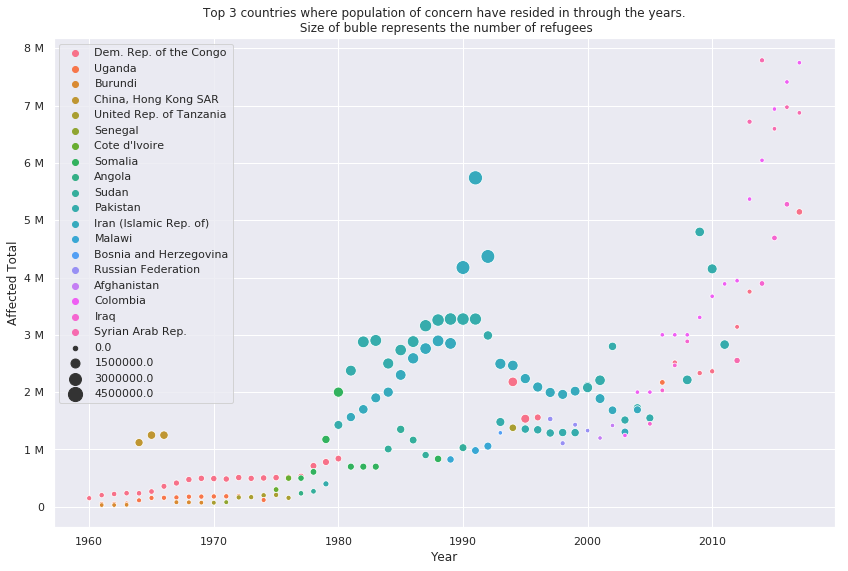

In [31]:
plt.figure(figsize=(14,9))
ax = sns.scatterplot(x=[data['year'] for data in out_residing], 
                     y=[data['affectedTotal'] for data in out_residing], 
                     hue=[data['country'] for data in out_residing],
                     size=[data['affectedRefugees'] for data in out_residing],
                     sizes=(20, 200))
ax.set_title("Top {0} countries where population of concern have resided in through the years.\n " 
             "Size of buble represents the number of refugees".format(top_number_limit_C1))
ax.set_ylabel('Affected Total')
ax.set_xlabel('Year')
ax.yaxis.set_major_formatter(ticker.EngFormatter())

 - Originating from:

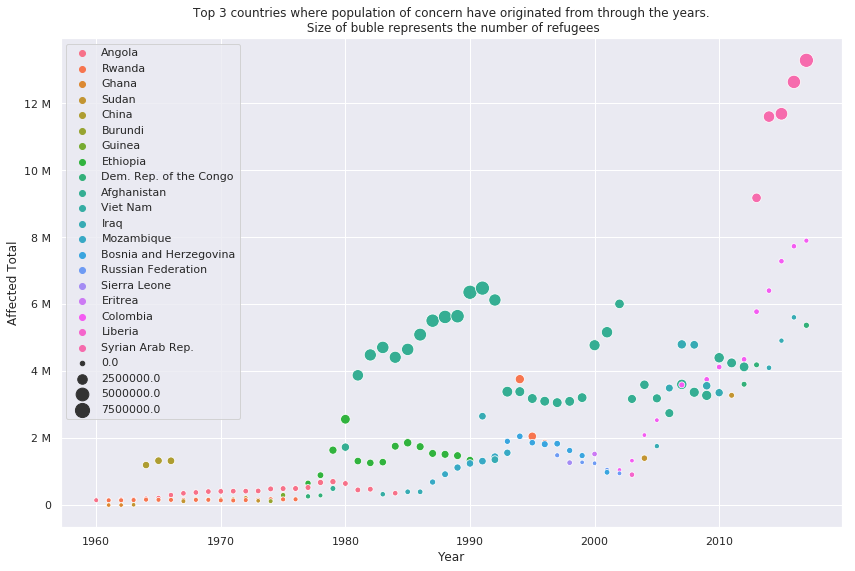

In [32]:
plt.figure(figsize=(14,9))
ax = sns.scatterplot(x=[data['year'] for data in out_originating], 
                     y=[data['affectedTotal'] for data in out_originating], 
                     hue=[data['country'] for data in out_originating],
                     size=[data['affectedRefugees'] for data in out_originating],
                     sizes=(20, 200))
ax.set_title("Top {0} countries where population of concern have originated from through the years.\n " 
             "Size of buble represents the number of refugees".format(top_number_limit_C1))
ax.set_ylabel('Affected Total')
ax.set_xlabel('Year')
ax.yaxis.set_major_formatter(ticker.EngFormatter())

### Analyse refugees and asylum seekes figures for one particular country in a given a given year

 - Given year and country of residence, obtain the number of people that request asylum and their country of origin:

In [33]:
def origin_countries_given_residence_and_year(tx,year,country_residence):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]-(b:CountryYear) "
                         "WHERE a.year={0} AND a.country={1} " 
                         "RETURN b.country AS country, "                         
                         "r.affected_refugees AS affectedRefugees, "
                         "r.affected_asylum AS affectedAsylum, "
                         "r.affected_total AS affectedTotal "
                         "ORDER BY affectedTotal DESC"
                  .format(year,country_residence))

 - Given year and country of origin, obtain the number of people that request asylum and their country of residence:

In [34]:
def origin_countries_given_origin_and_year(tx,year,country_origin):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->(b:CountryYear) "
                         "WHERE a.year={0} AND a.country={1} " 
                         "RETURN b.country as country, "
                         "r.affected_refugees AS affectedRefugees, "
                         "r.affected_asylum AS affectedAsylum, "
                         "r.affected_total AS affectedTotal "
                         "ORDER BY affectedTotal DESC".format(year,country_origin))

Calling both previous functions and ploting results for a year/country:

In [35]:
country_C2 = '"Spain"'
year_C2 = 2017

In [36]:
with driver.session() as session:
    countries_given_residence = session.read_transaction(origin_countries_given_residence_and_year, year_C2, country_C2).data()
    countries_given_origin = session.read_transaction(origin_countries_given_origin_and_year, year_C2, country_C2).data()

Remove None and turn into 0 for ploting:

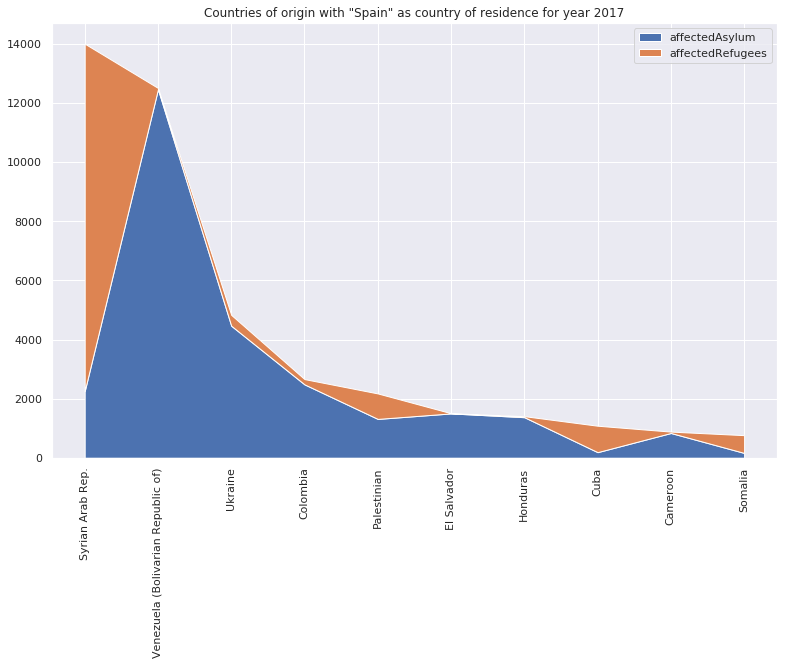

In [37]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(13)
ax.stackplot([data['country'] for data in countries_given_residence][0:10], 
             [int(data['affectedAsylum'] or 0) for data in countries_given_residence][0:10], 
             [int(data['affectedRefugees'] or 0) for data in countries_given_residence][0:10])
plt.xticks(rotation='vertical')
plt.legend(('affectedAsylum', 'affectedRefugees'))
plt.title("Countries of origin with {0} as country of residence for year {1}".format(country_C2, year_C2))
plt.show()

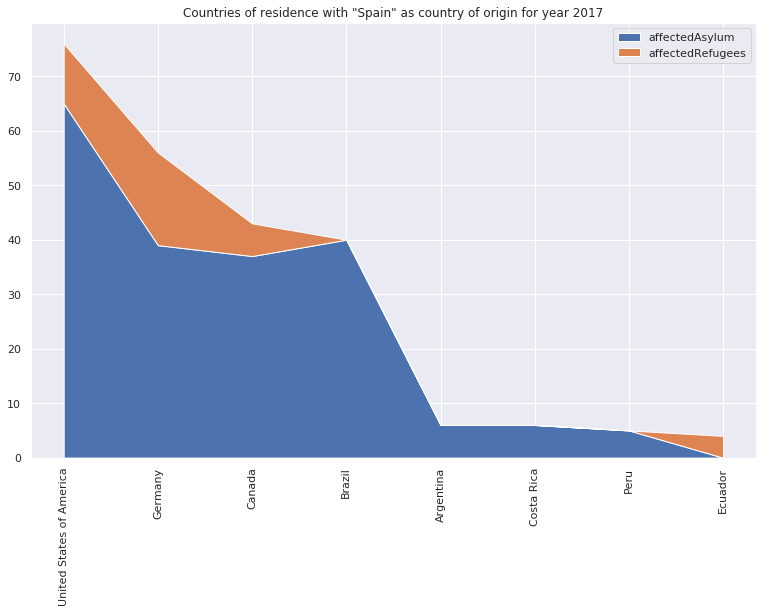

In [38]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(13)
ax.stackplot([data['country'] for data in countries_given_origin][0:10], 
             [int(data['affectedAsylum'] or 0) for data in countries_given_origin][0:10], 
             [int(data['affectedRefugees'] or 0) for data in countries_given_origin][0:10])
plt.xticks(rotation='vertical')
plt.legend(('affectedAsylum', 'affectedRefugees'))
plt.title("Countries of residence with {0} as country of origin for year {1}".format(country_C2, year_C2))
plt.show()

https://matplotlib.org/gallery.html
    
https://seaborn.pydata.org/examples/index.html

https://matplotlib.org/examples/lines_bars_and_markers/barh_demo.html

## Testing how to Export a subgraph to different formats

In [18]:
def export_graph(tx,format_of_export, country, year):
    return tx.run("CALL apoc.export.{0}.query( "
                  "'MATCH p=()<-[r:RESIDE_IN]-(n) WHERE n.year={2} AND n.country={1} RETURN p', " 
                  "'../neo4j/import/prueba.{0}', {{}} )".format(format_of_export, country, year))

to graphml

In [19]:
with driver.session() as session:
    session.read_transaction(export_graph, "graphml", '"Spain"', "2017")

to json

In [20]:
with driver.session() as session:
    session.read_transaction(export_graph, "json",'"Spain"', "2017")